# TF-IDF

## Imports and Setup

### Install missing packages

In [1]:
!pip install nltk
!pip install gensim
!pip install python-Levenshtein

  Using cached nltk-3.6.2-py3-none-any.whl (1.5 MB)
  Using cached gensim-4.0.1-cp38-cp38-manylinux1_x86_64.whl (23.9 MB)
  Using cached smart_open-5.1.0-py3-none-any.whl (57 kB)
  Using cached python_Levenshtein-0.12.2-cp38-cp38-linux_x86_64.whl


### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import glob

from transformers import BertTokenizer
from transformers import BertModel
from transformers import AutoModel
from transformers import AutoTokenizer

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import xml.etree.ElementTree as ET

from nltk.probability import FreqDist

from functools import reduce
from nltk import ngrams
# Used for building models for classifying:
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

## Define constants

In [4]:
############### THIS IS THE MAX ACCEPTABLE LENGTH (80 CHARS) ###################
#data = "~/shared/data/project/training/one_hour"
TRAIN_DATA_LOCATION = "train.pkl"
TEST_DATA_LOCATION = "test.pkl"
random.seed(123)

namespace = "{http://www.tei-c.org/ns/1.0}"

N_LANGUAGES = 5

## Read the data

In [5]:
train_data = pd.read_pickle(TRAIN_DATA_LOCATION)
test_data = pd.read_pickle(TEST_DATA_LOCATION)

In [6]:
train_data = train_data[train_data["language"] == '488B32D24BD4BB44172EB981C1BCA6FA']
test_data = test_data[test_data["language"] == '488B32D24BD4BB44172EB981C1BCA6FA']

In [7]:
# Take a small dataset for developing
train_data = train_data.head(2000)
test_data = test_data.head(2000)

### Understand the data

In [8]:
print("TRAINING DATASET:")
print("Type: " + str(type(train_data)))
#print(train_data.head(3))
print("shape:" + str(train_data.shape))
print(train_data.columns)
print("------------------------")
print("TESTING DATASET:")
print("Type: " + str(type(test_data)))
#print(test_data.head(3))
print("shape:" + str(test_data.shape))
print(test_data.columns)

TRAINING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(2000, 24)
Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'type', 'language', 'timestamp', 'user_id_engaged',
       'follower_count_engaged', 'following_count_engaged',
       'is_verified_engaged', 'account_creation_time_engaged',
       'user_id_engaging', 'follower_count_engaging',
       'following_count_engaging', 'is_verified_engaging',
       'account_creation_time_engaging', 'engagee_follows_engager',
       'reply_engagement_timestamp', 'retweet_engagement_timestamp',
       'retweet_with_comment_engagement_timestamp',
       'like_engagement_timestamp'],
      dtype='object')
------------------------
TESTING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(2000, 24)
Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'type', 'language', 'timestamp', 'user_id_engaged',
       'follower_count_engaged', 'following_count_engaged',
      

## Preprocessing

### Convert targets to binary

In [9]:
############### THIS IS THE MAX ACCEPTABLE LENGTH (80 CHARS) ###################
target_variables = ["reply_engagement_timestamp", 
                    "retweet_engagement_timestamp", 
                    "retweet_with_comment_engagement_timestamp", 
                    "like_engagement_timestamp"]

#for tgt_var in target_variables:
#    train_data.loc[~train_data[tgt_var].isna(), tgt_var] = 1
#    train_data.loc[train_data[tgt_var].isna(), tgt_var] = 0
#    test_data.loc[~test_data[tgt_var].isna(), tgt_var] = 1
#    test_data.loc[test_data[tgt_var].isna(), tgt_var] = 0
for tgt_var in target_variables:
    train_data.loc[~train_data[tgt_var].isna(), tgt_var] = 'Yes'
    train_data.loc[train_data[tgt_var].isna(), tgt_var] = 'No'
    test_data.loc[~test_data[tgt_var].isna(), tgt_var] = 'Yes'
    test_data.loc[test_data[tgt_var].isna(), tgt_var] = 'No'

### Remove irrevelant columns & rename

In [10]:
train_data = train_data[["user_id_engaging"
            , "tweet_id"
            , "language"
            , "text_tokens"
            , "reply_engagement_timestamp"
            , "retweet_engagement_timestamp"
            , "retweet_with_comment_engagement_timestamp"
            , "like_engagement_timestamp"
           ]]

train_data.rename(columns={'user_id_engaging': 'user_id'
                         , 'reply_engagement_timestamp': 'reply'
                         , 'retweet_engagement_timestamp':'retweet'
                         , 'retweet_with_comment_engagement_timestamp': 'retweet_with_comment'
                         , 'like_engagement_timestamp': 'like'
                         }, inplace=True)

test_data = test_data[["user_id_engaging"
            , "tweet_id"
            , "language"
            , "text_tokens"
            , "reply_engagement_timestamp"
            , "retweet_engagement_timestamp"
            , "retweet_with_comment_engagement_timestamp"
            , "like_engagement_timestamp"
           ]]

test_data.rename(columns={'user_id_engaging': 'user_id'
                         , 'reply_engagement_timestamp': 'reply'
                         , 'retweet_engagement_timestamp':'retweet'
                         , 'retweet_with_comment_engagement_timestamp': 'retweet_with_comment'
                         , 'like_engagement_timestamp': 'like'
                         }, inplace=True)

### Detokenize

In [11]:
############### THIS IS THE MAX ACCEPTABLE LENGTH (80 CHARS) ###################
## Generate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_data['Detokenized'] = train_data.apply(lambda row : tokenizer.decode(row['text_tokens'])
                             , axis = 1)

test_data['Detokenized'] = test_data.apply(lambda row : tokenizer.decode(row['text_tokens'])
                             , axis = 1)

## Figure out which languages to use

In [12]:
############### THIS IS THE MAX ACCEPTABLE LENGTH (80 CHARS) ###################
train_languages_sorted = train_data.groupby("language")\
                        .count()\
                        .sort_values("text_tokens", ascending=False)\
                        .text_tokens
train_top_n_languages = train_languages_sorted.head(N_LANGUAGES).index
print(train_top_n_languages)

test_languages_sorted = test_data.groupby("language")\
                        .count()\
                        .sort_values("text_tokens", ascending=False)\
                        .text_tokens
test_top_n_languages = test_languages_sorted.head(N_LANGUAGES).index
print(test_top_n_languages)

Index(['488B32D24BD4BB44172EB981C1BCA6FA'], dtype='object', name='language')
Index(['488B32D24BD4BB44172EB981C1BCA6FA'], dtype='object', name='language')


In [13]:
print(train_data.language.value_counts())
print(test_data.language.value_counts())

488B32D24BD4BB44172EB981C1BCA6FA    2000
Name: language, dtype: int64
488B32D24BD4BB44172EB981C1BCA6FA    2000
Name: language, dtype: int64


in case of TFIDF you could compute a similarity for all tweets where user engaged vs did not engage and come up with a probability this way

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer(#stop_words='english'
                             #,
                             #   ngram_range=(1, 5)
                             #, lowercase=True
                             #, 
    max_features=15000
                            )

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(train_data.Detokenized)

# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

(2000, 3924)


In [15]:
tfidf_matrix

<2000x3924 sparse matrix of type '<class 'numpy.float64'>'
	with 42069 stored elements in Compressed Sparse Row format>

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [0.01028029 0.01028029 1.         ... 0.01073828 0.01073828 0.04476994]
 ...
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.00236452 0.00236452 0.04476994 ... 0.00354955 0.00354955 1.        ]]


In [17]:
import time

# Record start time
start = time.time()

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Print cosine similarity matrix
print(cosine_sim)

# Print time taken
print("Time taken: %s seconds" % (time.time() - start))

[[1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [0.01028029 0.01028029 1.         ... 0.01073828 0.01073828 0.04476994]
 ...
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.00236452 0.00236452 0.04476994 ... 0.00354955 0.00354955 1.        ]]
Time taken: 0.13663458824157715 seconds


In [18]:
import time
from sklearn.metrics.pairwise import linear_kernel

# Record start time
start = time.time()

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Print cosine similarity matrix
print(cosine_sim)

# Print time taken
print("Time taken: %s seconds" % (time.time() - start))

[[1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [1.         1.         0.01028029 ... 0.01269466 0.01269466 0.00236452]
 [0.01028029 0.01028029 1.         ... 0.01073828 0.01073828 0.04476994]
 ...
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.01269466 0.01269466 0.01073828 ... 1.         1.         0.00354955]
 [0.00236452 0.00236452 0.04476994 ... 0.00354955 0.00354955 1.        ]]
Time taken: 0.12505340576171875 seconds


In [19]:
train_data.index

Int64Index([   8,    9,   22,   26,   27,   28,   29,   30,   31,   32,
            ...
            7467, 7468, 7469, 7470, 7471, 7474, 7475, 7476, 7477, 7478],
           dtype='int64', length=2000)

In [20]:
indices = pd.Series(train_data.index, index=train_data['Detokenized']).drop_duplicates()


In [21]:
indices

Detokenized
[CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]       8
[CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]       9
[CLS] [UNK] " elevated " ( non - severe ) thunderstorms tomorrow... ¶ ¶ Another look at the timing & amp ; your 7 Day Forecast coming up in 15 minutes on @ CBS _ 42. # alwx https : / / t. co / dHvhmvKKxm [SEP]                                                                             

In [22]:
def get_recommendations(title, cosine_sim, indices):
    # Get the index of the movie that matches the title
    idx = indices[title]
    print("IDX:")
    print(idx)
    # Get the pairwsie similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[1:11]
    #sim_scores = sim_scores[:1]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return train_data['Detokenized'].iloc[movie_indices]

In [23]:
sim_scores = list(enumerate(cosine_sim[9]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores



[(4, 0.9999999999999996),
 (5, 0.9999999999999996),
 (6, 0.9999999999999996),
 (7, 0.9999999999999996),
 (8, 0.9999999999999996),
 (9, 0.9999999999999996),
 (1883, 0.22262740396513545),
 (1884, 0.22262740396513545),
 (1638, 0.19637397882471913),
 (455, 0.18851733783599592),
 (456, 0.18851733783599592),
 (457, 0.18851733783599592),
 (1651, 0.187474393197875),
 (1055, 0.1577225762694132),
 (1056, 0.1577225762694132),
 (1627, 0.14899975439681892),
 (1628, 0.14899975439681892),
 (1629, 0.14899975439681892),
 (1462, 0.140145657945363),
 (155, 0.1380722816989948),
 (156, 0.1380722816989948),
 (1885, 0.1338404848670109),
 (1886, 0.1338404848670109),
 (1887, 0.1338404848670109),
 (1888, 0.1338404848670109),
 (1092, 0.1296132385032058),
 (79, 0.1225753278018596),
 (80, 0.1225753278018596),
 (81, 0.1225753278018596),
 (82, 0.1225753278018596),
 (83, 0.1225753278018596),
 (84, 0.1225753278018596),
 (85, 0.1225753278018596),
 (86, 0.1225753278018596),
 (87, 0.1225753278018596),
 (88, 0.12257532780

In [24]:
def similarity_between(unseen_doc, previous_doc):
    sim = 1
    return sim

def find_most_similar(target_Tweet, top_n=50):
    res = 1
    return res

In [25]:
stopwords_list = ['[CLS]', '[UNK]']
#tfidf = TfidfVectorizer()#stop_words='english')

# Construct the TF-IDF matrix
#tfidf_matrix = tfidf.fit_transform(train_data.Detokenized)

# Generate the cosine similarity matrix
#cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Generate recommendations
res = get_recommendations(1, cosine_sim, indices)
res

IDX:
9
[(5, 0.9999999999999996), (6, 0.9999999999999996), (7, 0.9999999999999996), (8, 0.9999999999999996), (9, 0.9999999999999996), (1883, 0.22262740396513545), (1884, 0.22262740396513545), (1638, 0.19637397882471913), (455, 0.18851733783599592), (456, 0.18851733783599592)]


28      [CLS] [UNK] She [UNK] s one of those who is wi...
29      [CLS] [UNK] She [UNK] s one of those who is wi...
30      [CLS] [UNK] She [UNK] s one of those who is wi...
31      [CLS] [UNK] She [UNK] s one of those who is wi...
32      [CLS] [UNK] She [UNK] s one of those who is wi...
7169    [CLS] she really went : [UNK] https : / / t. c...
7170    [CLS] she really went : [UNK] https : / / t. c...
6088    [CLS] [UNK] You, [UNK] she said, [UNK] are my ...
2212    [CLS] # HudsonValley delay % Thursday [UNK] ¶ ...
2213    [CLS] # HudsonValley delay % Thursday [UNK] ¶ ...
Name: Detokenized, dtype: object

In [26]:
train_data['Detokenized'].iloc[1368]

'[CLS] Citing the New York Times as a news source is like citing AOC as a scholar. [SEP]'

In [27]:
indices[1]
train_data.head(9)

user_id                          tweet_id  \
8   11612C81933A4F93C5F985AAFE3E04CB  E5DE595BFF4F548CE9CD32B599FAB516   
9   218A62BB3B0650FBFC37DC7E4B4A4634  E5DE595BFF4F548CE9CD32B599FAB516   
22  A6057F6F8412EC0CEC96B4803E6558B6  70FA489FEA0D824E6B39AB96BF16A903   
26  9C6841B85A13876E252EBFA627274205  486757C39BF7CF6016CCDC5C1919FF8B   
27  18194371682AC9F07DDD357776EE11A7  821B5D4A98CF158C3F14B1BD76E269D4   
28  4C11ABD651E573FCBA5B1E32072081B5  821B5D4A98CF158C3F14B1BD76E269D4   
29  581980065ACBD23CA37C3156C178DBA0  821B5D4A98CF158C3F14B1BD76E269D4   
30  64F82C70D17319B4D43F2725DA27B783  821B5D4A98CF158C3F14B1BD76E269D4   
31  DEB026C5ED654C06A7C4B54898E186F9  821B5D4A98CF158C3F14B1BD76E269D4   

                            language  \
8   488B32D24BD4BB44172EB981C1BCA6FA   
9   488B32D24BD4BB44172EB981C1BCA6FA   
22  488B32D24BD4BB44172EB981C1BCA6FA   
26  488B32D24BD4BB44172EB981C1BCA6FA   
27  488B32D24BD4BB44172EB981C1BCA6FA   
28  488B32D24BD4BB44172EB981C1BCA6FA   
29  488B32D24BD4BB44172EB981C1BCA6FA   
30  488B32D24BD4BB44172EB981C1BCA6FA   
31  488B32D24BD4BB44172EB981C1BCA6FA   

                                          text_tokens reply retweet  \
8   [101, 100, 100, 216, 216, 137, 10183, 10115, 1...    No      No   
9   [101, 100, 100, 216, 216, 137, 10183, 10115, 1...    No     Yes   
22  [101, 100, 107, 69202, 107, 113, 10446, 118, 3...    No      No   
26  [101, 100, 108, 39774, 50655, 51036, 108, 9746...    No      No   
27  [101, 100, 11149, 100, 187, 10464, 10108, 1267...    No      No   
28  [101, 100, 11149, 100, 187, 10464, 10108, 1267...    No      No   
29  [101, 100, 11149, 100, 187, 10464, 10108, 1267...    No      No   
30  [101, 100, 11149, 100, 187, 10464, 10108, 1267...    No      No   
31  [101, 100, 11149, 100, 187, 10464, 10108, 1267...    No      No   

   retweet_with_comment like  \
8                    No  Yes   
9                    No  Yes   
22                   No   No   
26                   No  Yes   
27                   No   No   
28                   No   No   
29                   No   No   
30                   No   No   
31                   No   No   

                                          Detokenized  
8   [CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockos...  
9   [CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockos...  
22  [CLS] [UNK] " elevated " ( non - severe ) thun...  
26  [CLS] [UNK] # CHENLE # 천러 ¶ © & amp ; dolphin ...  
27  [CLS] [UNK] She [UNK] s one of those who is wi...  
28  [CLS] [UNK] She [UNK] s one of those who is wi...  
29  [CLS] [UNK] She [UNK] s one of those who is wi...  
30  [CLS] [UNK] She [UNK] s one of those who is wi...  
31  [CLS] [UNK] She [UNK] s one of those who is wi...

In [28]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1,1))#, 3))
x_train_tfidf = tvec.fit_transform(train_data['Detokenized'])
x_validation_tfidf = tvec.transform(test_data['Detokenized'])

reply


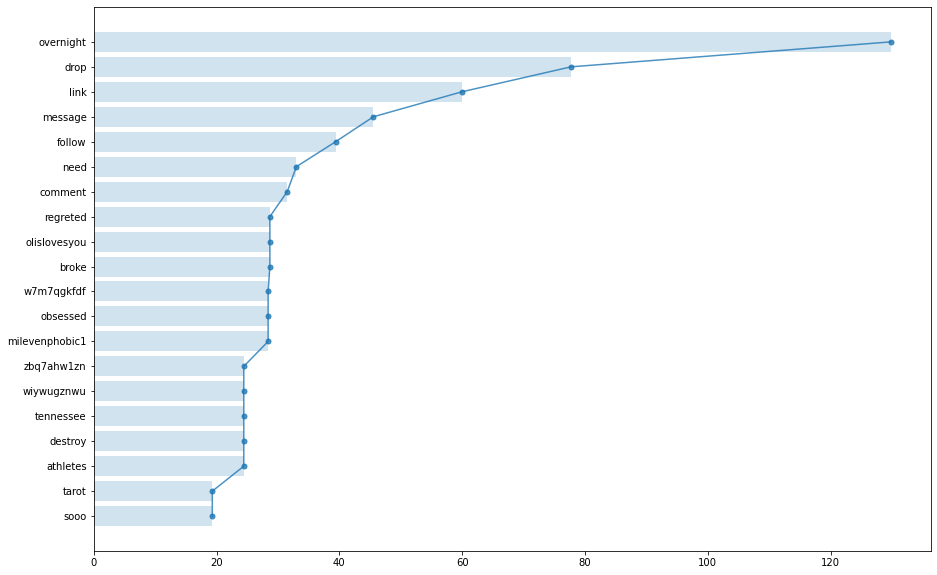

retweet


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48288 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_te

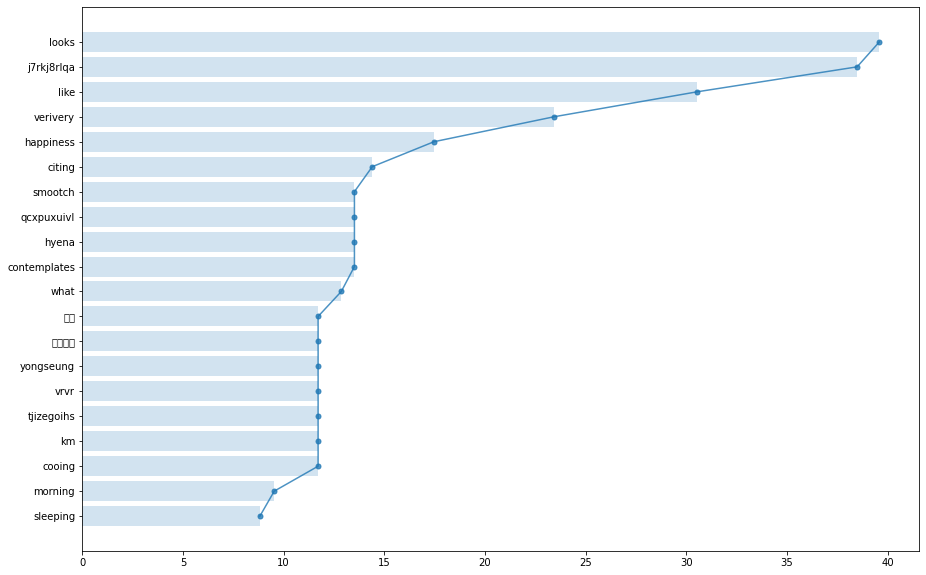

retweet_with_comment


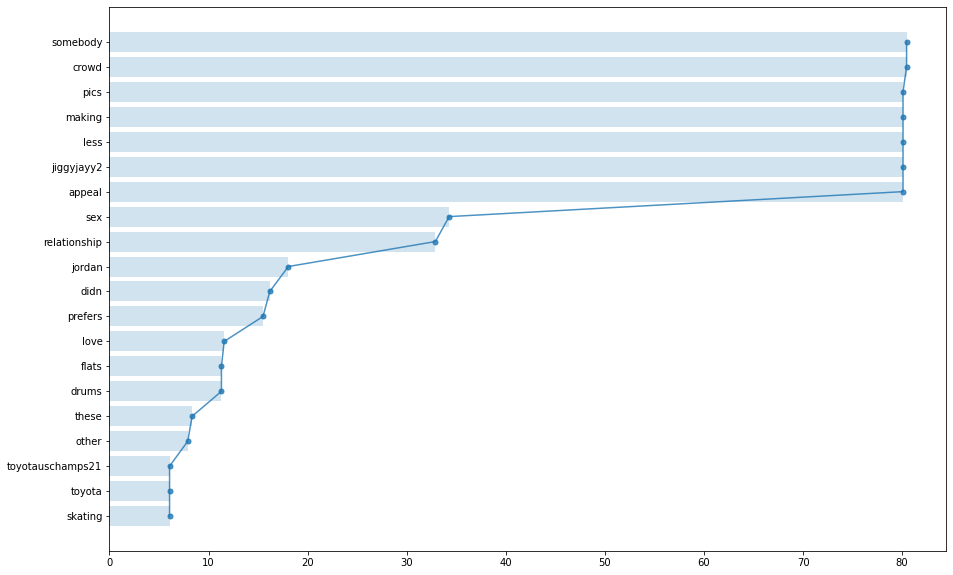

like


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0, flags=flags)


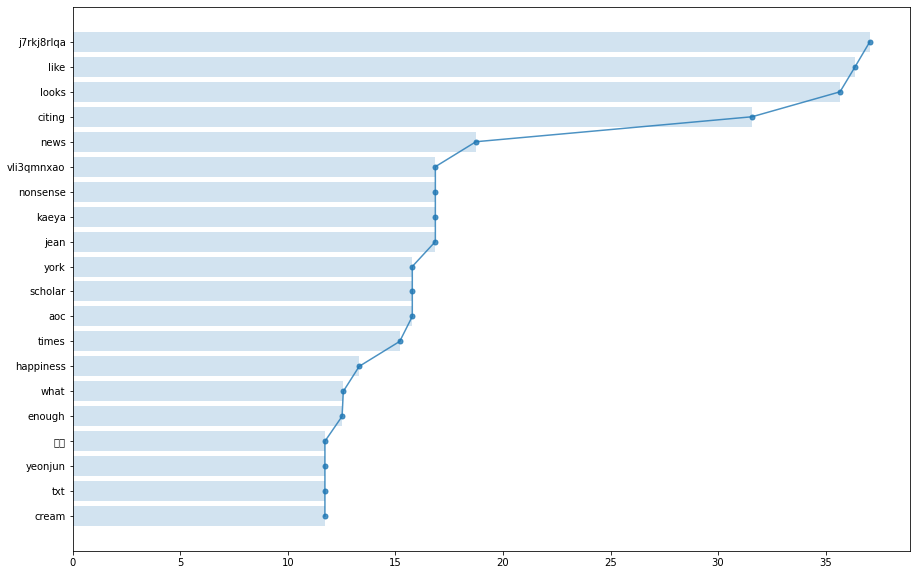

In [29]:
engagement_targets = ['reply', 'retweet','retweet_with_comment', 'like']

for tgt in engagement_targets:
    print(tgt)
    
    chi2score = chi2(x_train_tfidf, train_data[tgt])[0]

    plt.figure(figsize=(15,10))
    wscores = list(zip(tvec.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    #print(wchi2)
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.show()

## PCA

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler(with_mean=False)
d2v_ugdbow_tgdmm_std = scaler.fit_transform(x_train_tfidf)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(x_validation_tfidf)

print(type(d2v_ugdbow_tgdmm_std))
print(d2v_ugdbow_tgdmm_std.shape)
d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, d2v_pca.n_components_+1)
ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

<class 'scipy.sparse.csr.csr_matrix'>
(2000, 3924)


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [31]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
X = sparse_random(100, 100, density=0.01, format='csr',random_state=42)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)
TruncatedSVD(n_components=5, n_iter=7, random_state=42)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)




[0.06460458 0.06339574 0.06394296 0.05352982 0.04061973]
0.28609283521378914
[1.55360944 1.5121377  1.51052009 1.37056529 1.19917045]


In [32]:
tsv = TruncatedSVD(n_components=10,algorithm='randomized',n_iter=5)#,n_iterations=5)
tfv = TfidfVectorizer(min_df=3
                      ,max_features=None
                      ,strip_accents='unicode'
                      ,analyzer='word'
                      ,token_pattern=r'\w{1,}'
                      ,ngram_range=(1, 2)
                      , use_idf=1
                      ,smooth_idf=1
                      ,sublinear_tf=1
                     )
tfv.fit(train_data['Detokenized'])
text = tfv.transform(train_data['Detokenized'])
tsv.fit(text)

type(tsv)
print(text)

  (0, 4718)	0.31737764964604964
  (0, 4660)	0.21944743222647262
  (0, 4178)	0.0779926817200214
  (0, 4176)	0.07713352958614324
  (0, 3907)	0.06880938150610132
  (0, 2460)	0.49646711715378705
  (0, 2216)	0.0779926817200214
  (0, 2215)	0.07795339574607035
  (0, 2120)	0.255355275866002
  (0, 1082)	0.0779926817200214
  (0, 1063)	0.23117580461013587
  (0, 955)	0.06880938150610132
  (0, 208)	0.6680132734929102
  (1, 4718)	0.31737764964604964
  (1, 4660)	0.21944743222647262
  (1, 4178)	0.0779926817200214
  (1, 4176)	0.07713352958614324
  (1, 3907)	0.06880938150610132
  (1, 2460)	0.49646711715378705
  (1, 2216)	0.0779926817200214
  (1, 2215)	0.07795339574607035
  (1, 2120)	0.255355275866002
  (1, 1082)	0.0779926817200214
  (1, 1063)	0.23117580461013587
  (1, 955)	0.06880938150610132
  :	:
  (1998, 3895)	0.3665592802000882
  (1998, 3160)	0.12638714661219097
  (1998, 2848)	0.3665592802000882
  (1998, 2843)	0.2112828813267798
  (1998, 2216)	0.05758476298705164
  (1998, 2215)	0.05755575675917493
 

In [33]:
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

In [34]:
import re

In [35]:
train_data.Detokenized = train_data.Detokenized.str.replace('\d+', '', regex=True)

In [36]:
train_data.Detokenized.head(10)

8     [CLS] [UNK] [UNK] ¶ ¶ @ pornpleasure @ jockosr...
9     [CLS] [UNK] [UNK] ¶ ¶ @ pornpleasure @ jockosr...
22    [CLS] [UNK] " elevated " ( non - severe ) thun...
26    [CLS] [UNK] # CHENLE # 천러 ¶ © & amp ; dolphin ...
27    [CLS] [UNK] She [UNK] s one of those who is wi...
28    [CLS] [UNK] She [UNK] s one of those who is wi...
29    [CLS] [UNK] She [UNK] s one of those who is wi...
30    [CLS] [UNK] She [UNK] s one of those who is wi...
31    [CLS] [UNK] She [UNK] s one of those who is wi...
32    [CLS] [UNK] She [UNK] s one of those who is wi...
Name: Detokenized, dtype: object

In [37]:
#test_data.Detokenized = test_data.Detokenized.str.replace('\b[0-9][0-9.,-]*\b', 'NUMBER-SPECIAL-TOKEN', regex=True)
test_data.Detokenized = test_data.Detokenized.str.replace('\d+', '', regex=True)

In [38]:
vectorizer = TfidfVectorizer(min_df=3
                      ,max_features=None
                      ,strip_accents='unicode'
                      ,analyzer='word'
                      ,token_pattern=r'\w{1,}'
                      #,ngram_range=(1, 3)
                      ,ngram_range=(1, 1)
                      , use_idf=1
                      ,smooth_idf=1
                      ,sublinear_tf=1
                     )

In [39]:
tfidf_matrix = vectorizer.fit_transform(train_data.Detokenized)

In [40]:
train_data_tfidf = tvec.fit_transform(train_data['Detokenized'])
test_data_tfidf = tvec.transform(test_data['Detokenized'])

In [41]:
# Record start time
start = time.time()

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Print cosine similarity matrix
print(cosine_sim)
# Print time taken
print("Time taken: %s seconds" % (time.time() - start))

[[1.         1.         0.20580873 ... 0.06021581 0.06021581 0.01216831]
 [1.         1.         0.20580873 ... 0.06021581 0.06021581 0.01216831]
 [0.20580873 0.20580873 1.         ... 0.03791354 0.03791354 0.15063799]
 ...
 [0.06021581 0.06021581 0.03791354 ... 1.         1.         0.01090386]
 [0.06021581 0.06021581 0.03791354 ... 1.         1.         0.01090386]
 [0.01216831 0.01216831 0.15063799 ... 0.01090386 0.01090386 1.        ]]
Time taken: 0.1300821304321289 seconds


In [43]:
print(vectorizer)
vectorizer.get_feature_names()

TfidfVectorizer(min_df=3, smooth_idf=1, strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)


['_',
 'a',
 'ability',
 'about',
 'above',
 'abusive',
 'acb',
 'according',
 'accountable',
 'accused',
 'acknowledge',
 'across',
 'act',
 'action',
 'actions',
 'add',
 'additional',
 'address',
 'adexhxfj',
 'adorable',
 'advice',
 'advisory',
 'aew',
 'afp',
 'afro',
 'after',
 'again',
 'aggmjzhuxy',
 'ago',
 'aisle',
 'akyavluu',
 'al',
 'alan',
 'alanavi',
 'alayadj',
 'album',
 'all',
 'alley',
 'allow',
 'almost',
 'along',
 'already',
 'alright',
 'also',
 'alt',
 'always',
 'am',
 'amazing',
 'amberglenn',
 'amefkmcs',
 'amongus',
 'amount',
 'amp',
 'an',
 'anchor',
 'anchored',
 'and',
 'andrea',
 'ang',
 'angelawhite',
 'anishinaabe',
 'announce',
 'announced',
 'announcement',
 'annual',
 'anonymous',
 'another',
 'answered',
 'anthem',
 'anthony',
 'anticipates',
 'anticipating',
 'antique',
 'antonelli',
 'any',
 'anything',
 'aoc',
 'app',
 'applications',
 'applied',
 'appointed',
 'appreciation',
 'april',
 'arbor',
 'arborday',
 'arca',
 'are',
 'area',
 'areas',

In [45]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
#for n in [1, 10,100,1000,2000, 'all']:
for n in [100]:
    print("Hey")
    ch2 = SelectKBest(chi2, k=n)
    #ch2.fit_transform(x_train_tfidf, train_data['reply'])
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, train_data['reply'])
    print(x_train_chi2_selected.shape)
    x_validation_chi2_selected = ch2.transform(test_data_tfidf)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, train_data['reply'])
    score = clf.score(x_validation_chi2_selected, test_data['reply'])
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))
    
    mask = ch2.get_support() #list of booleans
    
    
    print(mask)
    new_features = [] # The list of your K best features

    #for bool, feature in zip(mask, vectorizer.get_feature_names()):
        #if bool:
            #new_features.append(feature)
            #new_features.append(list(zip(feature, chi2score)))
    #print(new_features)
    #print(chi2score)
    
    #mask = ch2.get_support()
    #new_features = features_dataframe.columns[mask]
    #print(new_features)
    
    plt.figure(figsize=(15,10))
    wscores = list(zip(vectorizer.get_feature_names(), chi2score))
    #wscores = list(zip(ch2.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.show()
    
ch2_result

ch2

Hey
(2000, 100)


ValueError: X has a different shape than during fitting.

In [46]:
ch2_result

[]

reply


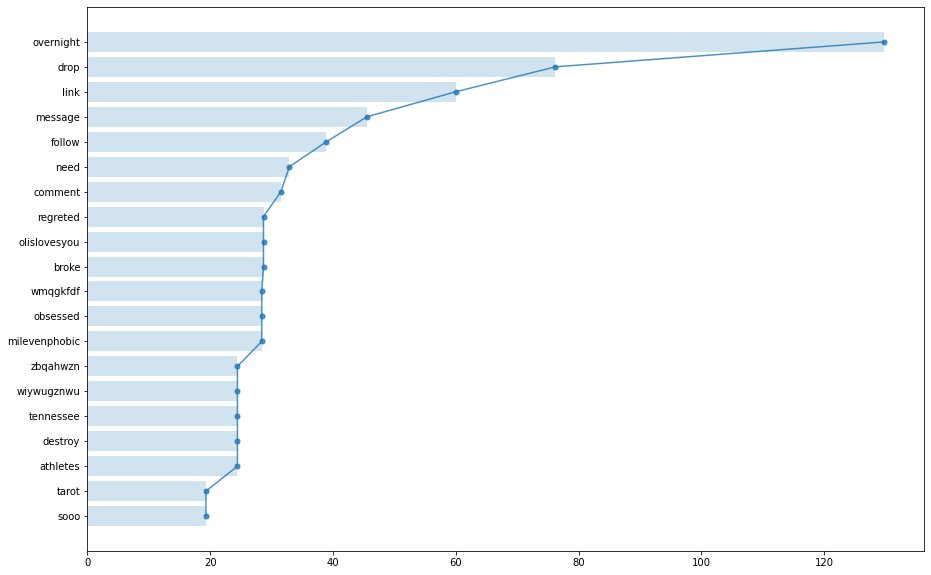

retweet


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48288 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_te

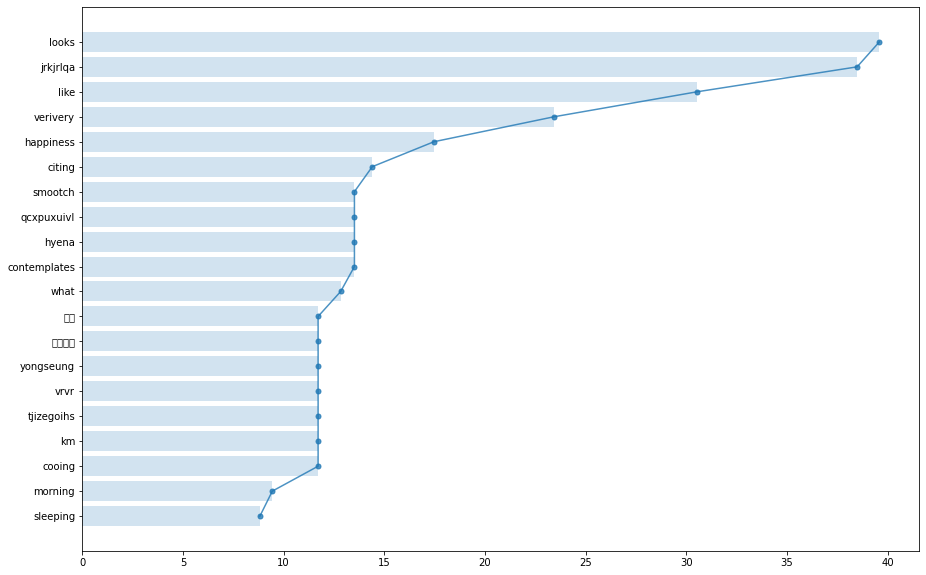

retweet_with_comment


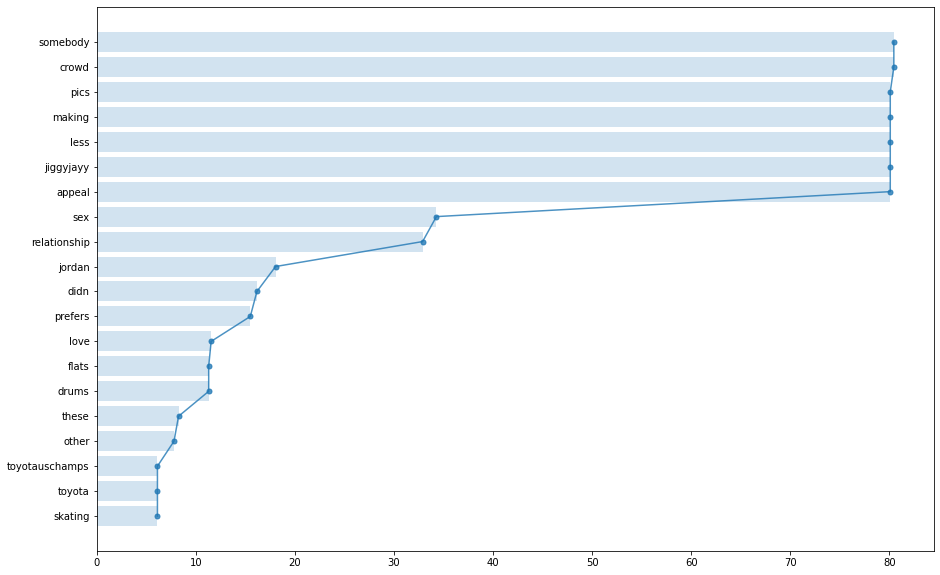

like


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0, flags=flags)


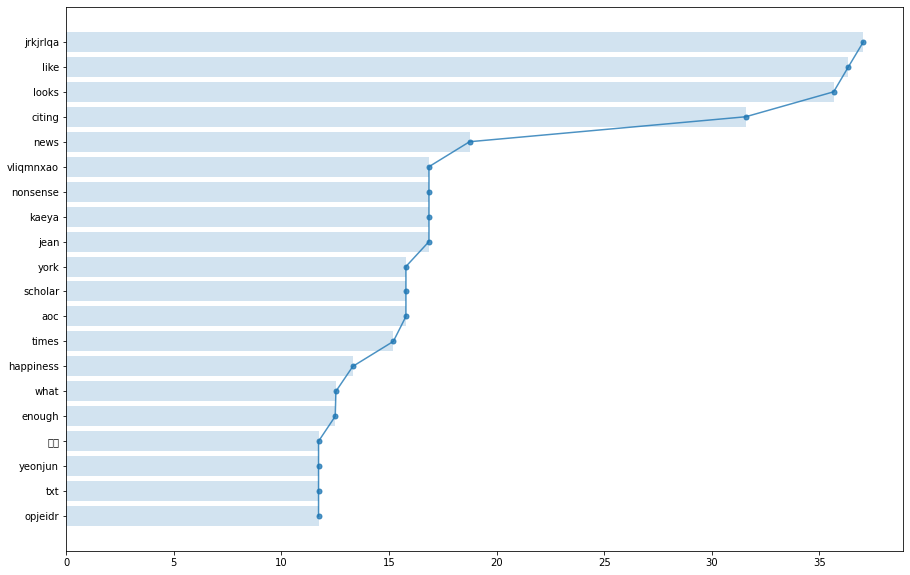

In [47]:
engagement_targets = ['reply', 'retweet','retweet_with_comment', 'like']

for tgt in engagement_targets:
    print(tgt)
    
    chi2score = chi2(train_data_tfidf, train_data[tgt])[0]

    plt.figure(figsize=(15,10))
    wscores = list(zip(tvec.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.show()

# Use Singular Value Decomposition (SVD)
Dimensionality reduction. PCR/PCA can't work on sparse matrices (return non-sparse). Hence SVD

In [48]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
#for n in [1, 10,100,1000,2000, 'all']:
for n in [10]:
    print("Hey")
    ch2 = SelectKBest(chi2, k=n)
    #print(ch2)
    #print(ch2.shape)
    #ch2.fit_transform(x_train_tfidf, train_data['reply'])
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, train_data['reply'])
    #print(ch2)
    #print(ch2.shape)
    #print(x_train_chi2_selected)
    print(x_train_chi2_selected.shape)
    #print(ch2.get_feature_names())
    
    
    x_validation_chi2_selected = ch2.transform(test_data_tfidf)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, train_data['reply'])
    score = clf.score(x_validation_chi2_selected, test_data['reply'])
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))
    
    mask = ch2.get_support() #list of booleans
    all_features = vectorizer.get_feature_names()
    
    chi2score = chi2(x_train_chi2_selected, train_data[tgt])[0]
    print("HEREHEREHEREHRER")
    print(x_train_chi2_selected)
    print(x_train_chi2_selected.shape)
    print(chi2score.shape)
    print(chi2score)
    
    print(mask)
    new_features = [] # The list of your K best features

    #for bool, feature in zip(mask, vectorizer.get_feature_names()):
        #if bool:
            #new_features.append(feature)
            #new_features.append(list(zip(feature, chi2score)))
    #print(new_features)
    #print(chi2score)
    
    mask = ch2.get_support()
    print(mask)
    #new_features = features_dataframe.columns[mask]
    #print(new_features)
    
    plt.figure(figsize=(15,10))
    wscores = list(zip(vectorizer.get_feature_names(), chi2score))
    #wscores = list(zip(ch2.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.show()
    
ch2_result

#ch2

Hey
(2000, 10)


ValueError: X has a different shape than during fitting.